## Question 2: Backprop using Auto-differentiation

In [1]:
import numpy as np
from utils import *
from matad import *
from copy import deepcopy
import matplotlib.pyplot as plt

# How to use the `Mat` class

In [2]:
# Mat is like Var, but it contains 2D arrays.
X = Mat([[1.,2],[3,4]])
A = Mat([[3,1.],[-1,0]])

In [3]:
X

Mat([[1. 2.]
 [3. 4.]])

In [4]:
F = X + tanh(A)
F()

array([[1.99505475, 2.76159416],
       [2.23840584, 4.        ]])

In [5]:
f = mse(X,A.val)
f

Mat([[9.25]])

# Dataset

In [6]:
# DiscreteMapping dataset
n_classes = 4
in_dim = 2

np.random.seed(479)
B = np.eye(n_classes)
A = 4.*np.random.rand(n_classes, in_dim)

ds = DiscreteMapping(A, B, n=300, noise=0.5)

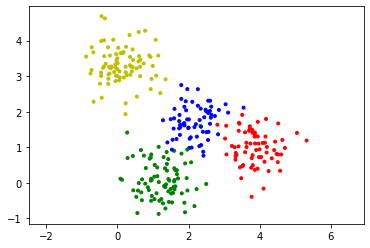

In [7]:
ds.plot()


In [8]:
# Recall how to get the inputs from the dataset.
ds.inputs()[:5]  # show the first 5

array([[ 0.34257426,  4.15186557],
       [ 0.60150449, -0.00753636],
       [ 0.00842397,  3.360606  ],
       [ 0.57950866, -0.21719826],
       [ 1.2077132 ,  2.52173365]])

In [9]:
# And how to get the targets.
ds.targets()[:5]  # show the first 5

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

# (a) `Mul` class and its wrapper `mul` (action required)

In [10]:
# The function "mul" is a wrapper for using the MatOperation class Mul.
def mul(a, b):
    '''
     v = mul(a, b)

     Matrix multiplication between two Mat objects.
     
     Inputs:
       a   Mat object, DxM
       b   Mat object, MxN
       
     Output:
       v   Mat object, DxN
       
     Note:
       v.creator points to the correspdoning Mul object
           of the MatOperation class
    '''
    return Mul([a, b])()

class Mul(MatOperation):
    def __init__(self, args):
        '''
         op = Mul(args)
         
         Creates a Mul object which implements matrix-matrix multiplication
         and its derivative.
         
         Inputs:
           args  list of two Mat objects
           
         Usage:
           a = Mat(...)
           b = Mat(...)
           op = Mul([a,b])  # creates the operation object
           v = op()         # evaluates the operation
        '''
        self.args = args

    def __call__(self):
        '''
         v = op() where op is a Mul object
         
         Evaluates the multiplication.
         The arguments (Mat objects) were specified at instatiation.
         
         Output:
           v   Mat containing the product
        '''
        c = Mat(self.args[0].val @ self.args[1].val)
        c.creator = self
        return c

    def backward(self, s=None):
        '''
         op.backward(s=None)
         
         Computes the derivative of the Mul operation with respect to its arguments,
         and applies that (using chain rule) to s, the input derivative.
         It then delivers the resulting derivatives to its arguments.
         
         Input:
           s  2D NumPy array (not a Mat object)
        '''
        #===== YOUR CODE HERE =====
        # These lines are placeholders. Replace them!
        self.args[0].backward(s@self.args[1].val.T) 
        self.args[1].backward(self.args[0].val.T@s) 


# `Layer` class and `Population` class

In [11]:
# Abstract base class for layers
class Layer(object):
    def __init__(self):
        return

    def __call__(self, x=None):
        raise NotImplementedError

In [12]:
# Population layer represents a layer of nodes, and applies the
# activation function. It also stores the input current (z) and
# the node activations (h).
class Population(Layer):
    '''
     lyr = Population(act=logistic)

     Creates a layer of nodes, and applies the activation
     to its input currents.

     Inputs:
       act  activation function
            This function should take a Mat object as input
            and output a Mat object.
          
     Usage:
       lyr.z  # Mat object, stores node input currents
       lyr.h  # Mat object, stores node activities
       lyr()  # returns lyr.h
       lyr(x) # applies activation function to x (Mat object)
    '''
    def __init__(self, act=relu):
        self.z = None  # Mat object
        self.h = None  # Mat object
        self.act = act
        self.params = []

    def __call__(self, x=None):
        if x is not None:
            self.h = self.act(x)
        return self.h

In [13]:
class DenseLayer(Layer):
    '''
     lyr = DenseLayer(from_nodes=1, to_nodes=1, act=logistic)

     The DenseLayer class puts the connection weights and
     activation function together into a single class.
     This compound layer is composed of:
       L1: a Connection object, followed by
       L2: a Population object.

     Inputs:
       from_nodes  number of nodes in sending layer
       to_nodes    number of nodes in receiving layer
       act         activation function
                   This function should take a Mat object as input
                   and output a Mat object.

     Usage:
       lyr.L1  # Connection layer object
       lyr.L2  # Population layer object
       h1 = lyr(h0) # returns activity of receiving layer, after
                    # passing h0 through L1 and then L2.
       h = lyr()  # returns the activities stored in lyr.L2
    '''
    def __init__(self, from_nodes=1, to_nodes=1, act=relu):
        self.L1 = Connection(from_nodes=from_nodes, to_nodes=to_nodes)
        self.L2 = Population(act=act)
        self.params = self.L1.params

    def __call__(self, x=None):
        if x is None:
            return self.L2.h
        else:
            return self.L2(self.L1(x))

# (b) `Connection` class (action required)

In [14]:
# Connection class
class Connection(Layer):
    '''
     lyr = Connection(from_nodes=1, to_nodes=1)

     Creates a layer of all-to-all connections.

     Inputs:
       from_nodes  number of nodes in source layer
       to_nodes    number of nodes in receiving layer
      
     Usage:
       lyr.W   # holds the connection weights (Mat object)
       lyr.b   # holds the biases (Mat object)
       lyr.params  # a list of parameters, [W,b]
       z = lyr(h)  # projects activities h (Mat) through the
                   # connection to get input currents z (Mat)
                   # ie. z = h @ W
    '''
    def __init__(self, from_nodes=1, to_nodes=1):
        super().__init__()
        self.Nin = from_nodes    # number of nodes in input (lower) layer
        self.Nout = to_nodes     # number of nodes in higher layer

        self.W = Mat( np.random.randn(self.Nin, self.Nout) / np.sqrt(self.Nin) )
        self.b = Mat( np.zeros(self.Nout) )
        self.params = [self.W, self.b]

    def __call__(self, x):
        if x is None:
            print('Should not call Connection without arguments.')
            return
        
        #===== YOUR CODE HERE =====
        self.temp = Mat(np.ones((len(x),1)))
        self.mat = (mul(x,self.W) + mul(self.temp , self.b))
        return self.mat # replace this line


# (c) `Network` class (action required)

In [15]:
class Network(object):
    '''
     net = Network()

     Creates a Network object, which represents a series of
     layers, and a cost (loss) function.

     Usage:
       net.lyr  # returns a list of Layer objects
       net.add_layer(L)  # appends the Layer L to the network
       y = net(x)  # feeds inputs x through the network
                   # x is a 2D numpy array or a Mat object
                   # returns y (Mat object)
       net.loss    # loss function (MatOperation object)
    '''
    def __init__(self):
        self.lyr = []
        self.loss = None

    def add_layer(self, L):
        self.lyr.append(L)

    def __call__(self, x):
        if type(x) not in (Mat, ):
            x = Mat(x)
        for l in self.lyr:
            x = l(x)
        return x

    def parameters(self):
        '''
         params = net.parameters()
         
         Returns a list of Mat objects of the connection weights and
         biases in the network (from bottom to top).
         Note that only Connection layers have these parameters.
        '''
        params = []
        for l in self.lyr:
            if l.params:  # skips empty lists
                params.append(l.params[0])
                params.append(l.params[1])
        return params
    
    def learn(self, ds, lrate=1., epochs=10):
        '''
         net.learn(ds, lrate=1., epochs=10)

         Runs backprop on the network, training on the data from
         the Dataset object ds.

         Inputs:
           ds       a Dataset object
           lrate    learning rate
           epochs   number of epochs to run
        '''
        losses = []
        x = ds.inputs()
        t = ds.targets()
        for epoch in range(epochs):

            y = self(x)             # forward pass

            #===== YOUR CODE BELOW =====
            loss = self.loss(y,t)  # replace this line!
            losses.append(loss.val[0,0])
            loss.zero_grad()
            loss.backward()

            params = self.parameters()
            for param in params:
                param.val = param.val - param.grad * lrate

            # Report progress
            if epoch%50==0:
                print(f'{epoch}: cost = {loss()[0,0]}')
        return losses

# Try it out
Your edited code should work on these lines

## Create a network

In [16]:
# Create a network object
# 2 input nodes -> 10 hidden nodes -> 3 output nodes
net = Network()
input_pop = Population(act=identity)
dl1 = DenseLayer(from_nodes=2, to_nodes=10, act=tanh)
dl2 = DenseLayer(from_nodes=10, to_nodes=4, act=softmax)
net.add_layer(input_pop)
net.add_layer(dl1)
net.add_layer(dl2)
# Loss function
net.loss = categorical_ce
lrate = 0.02

## Train and test the network

0: cost = 1.3552820707653803
50: cost = 0.9101158318316444
100: cost = 0.7700566570584857
150: cost = 0.6841208088141906
200: cost = 0.619805897449044
250: cost = 0.568155334544188
300: cost = 0.5246137352294221
350: cost = 0.4865468200103939
400: cost = 0.4525021145667384
450: cost = 0.4216998386217286


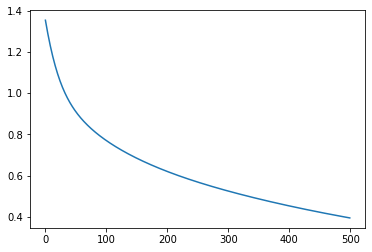

In [17]:
# you might have to run this a few times
losses = net.learn(ds, lrate=lrate, epochs=500)
plt.plot(losses);

In [18]:
y = net.lyr[-1]().val
print(y[:6,:])

[[0.92914504 0.00355344 0.00960588 0.05769564]
 [0.02929153 0.10052066 0.80882563 0.06136218]
 [0.92285974 0.00391944 0.01054199 0.06267884]
 [0.01644502 0.08955817 0.85540777 0.03858904]
 [0.58268506 0.031009   0.03976874 0.3465372 ]
 [0.00404836 0.72134512 0.17790833 0.09669818]]


In [19]:
ds.targets()[:6,:]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

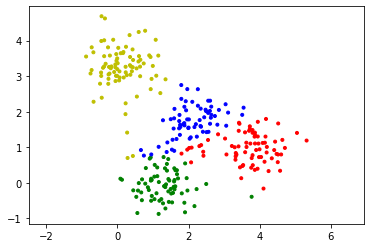

In [20]:
ds.plot(labels=y);

## You can also try your code on the `UClasses` dataset

Inputs are 2D
Targets are one-hot 2-vectors


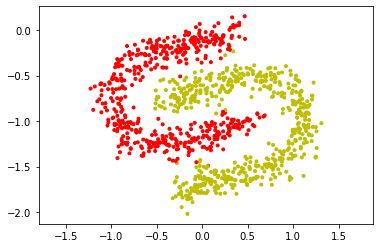

In [21]:
ds = UClasses(n=1000, binary=False)
print(f'Inputs are {ds.input_dim}D')
print(f'Targets are one-hot {ds.n_classes}-vectors')
ds.plot();

In [22]:
# Create a network object
# 2 input nodes -> 10 hidden nodes -> 3 output nodes
net = Network()
input_pop = Population(act=identity)
dl1 = DenseLayer(from_nodes=2, to_nodes=20, act=tanh)
dl1b = DenseLayer(from_nodes=20, to_nodes=10, act=tanh)
dl2 = DenseLayer(from_nodes=10, to_nodes=2, act=softmax)
net.add_layer(input_pop)
net.add_layer(dl1)
net.add_layer(dl1b)
net.add_layer(dl2)
# Loss function
net.loss = categorical_ce
lrate = 0.2

0: cost = 0.6058733751811853
50: cost = 0.37324213705606396
100: cost = 0.3590053761328471
150: cost = 0.27402257369075705
200: cost = 0.14113269253810012
250: cost = 0.045258917356560784
300: cost = 0.0358071423169873
350: cost = 0.031433153054676706
400: cost = 0.028794371967289203
450: cost = 0.026946297142297085
500: cost = 0.025525728403691432
550: cost = 0.02436340611509457
600: cost = 0.02337027768848424
650: cost = 0.022496226379160638
700: cost = 0.02171224903122463
750: cost = 0.021001561280773802
800: cost = 0.020354586860321378
850: cost = 0.019765826554609834
900: cost = 0.019231746772021226
950: cost = 0.018749336602114433


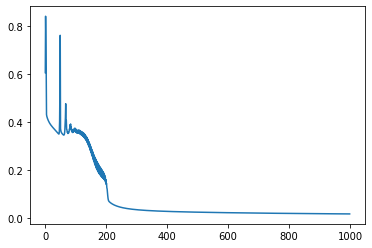

In [23]:
# You might need to run this a couple times
losses = net.learn(ds, lrate=1., epochs=1000)
plt.plot(losses);

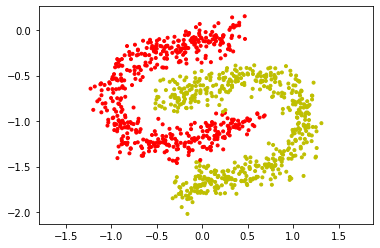

In [24]:
ds.plot(labels=net(ds.inputs())())